## Optimal wind farm cable routing: Modeling branches and offshore transformer modules




Let G=(V,A),a complete and loop-free directed graph,V is a set of node that is partitioned into $(V_{t},V_{0},V_{s})$ and A is a set of edge that represents all possible connection between nodes.Each node can be a turbine, a steiner node or a substation. The set $V_t$ is a partition that contains all turbines available, the $V_0$ is the set of all substations and $V_s$ is the set of all Steiner nodes. The Steiner node is usefull when in the path there is a obstacle that must be avoided to continue with link. 

Every node has a power production that is denote as $P_{h}$, if the node is a turbine the $P_{h} \geq 0$, if it is a Steiner node the $P_{h} = 0$ instead for a substation the $P_{h} \geq -1$.

Let $T$ A node set that contains all different cable types that can be used. Each cable $t$ haS a capacity $k_t$ and a unit cost $u_t \geq 0$.The unit cost $u_t$ is usefull to calculate the $c^t_i,j = u_t * dist(i,j)$ that is the cost of each arc $(i,j) \in A$ covered by cable $t \in T$.


### Decision Variables

$$
x^t_{ij} = \begin{cases}
1 \text{ iff arc $(i, j)$ is constructed with cable type t $∈$ T} \\
0 \text { otherwise}
\end{cases}
$$


$$
y_{ij}= \{\text{indicate whether an arc $(i, j)$ is built with any type of cable. } (i,j)\}
$$

$$
f^k_{ij} = \{\text{representing the energy flow from i to j }\}
$$


### Constraints


\begin{alignat}{3}
\min \sum_{({i,j})  \in A} \sum_{t  \in T} c^t_{ij}x^t_{i,j} &&\\
\sum_{t \in T} x^t_{i,j} = y_{i,j} &&\;\;  {(i,j)} \in A\\
\sum_{i \in V : i \not= h} f_{h,i} - f_{i,h} = P_{h} &&\;\; h \in V_{t} \cup V_{s}\\
\sum_{t \in T} k_{t}x^t_{i,j} \geq f_{i,j} &&\;\;  {(i,j)} \in A\\
\sum_{j \in V : j \not= h} y_{h,j} = 1 &&\;\; h \in V_{t}\\
\sum_{j \in V : j \not= h} y_{h,j} = 0 &&\;\; h \in V_{t}\\
\sum_{j \in V : j \not= h} y_{h,j} \leq 1  &&\;\; h \in V_{s}\\
\sum_{i \in V : j \not= h} y_{i,h} \leq 1  &&\;\; h \in V_{s}\\
\sum_{i \in V : j \not= h} y_{i,h} \leq C  &&\;\; h \in V_{t}\\
 y_{i,j}+y_{j,i}+y_{h,k}+y_{k,h} \leq 1  &&\;\; \;\; \forall \text{ crossing segments (i,j) and (h,k)}\\
\end{alignat}

In [23]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
import pygraphviz as pygv
import os
import matplotlib.pyplot as plt
import math
from IPython.display import SVG, display
import random
import numpy as np

In this box I generate a complete graph with 51 nodes and everyone has an attribute 'tp' that indicates the partition to which it belongs.
The list 'cables' represents all cable that can be used to connect nodes.

In [ ]:
G = nx.Graph()
nodes=[]
cables=[{'type':"black", 'unit':393,'flow_max':24},
        {'type':"green", 'unit':460,'flow_max':32},
        {'type':"blue", 'unit':540,'flow_max':40}]

max_cable_subst=12 # max cable connected to substation
    
for i in range(0,51):
    if(i!=0 and i%2==0):
       G.add_node(i,tp=0) #Vt partizione delle turbine
    else:
        if(i==0):
            G.add_node(i,tp=-1) #V0 partizione per la substation
        else:
            G.add_node(i,tp=1) #Vs partizione per la substation
    for j in range(0,51):
            if j!=i:
                G.add_edge(i,j)               
G=G.to_directed()

In [3]:
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 51 nodes and 2550 edges


In this box I draw the graph with label to recognize the turbine, the Steiner node and the substation, respectively 'T', 'S' and 'Sbs'. 

I know the graph is puzzling but it is a similar example that the paper shows. 

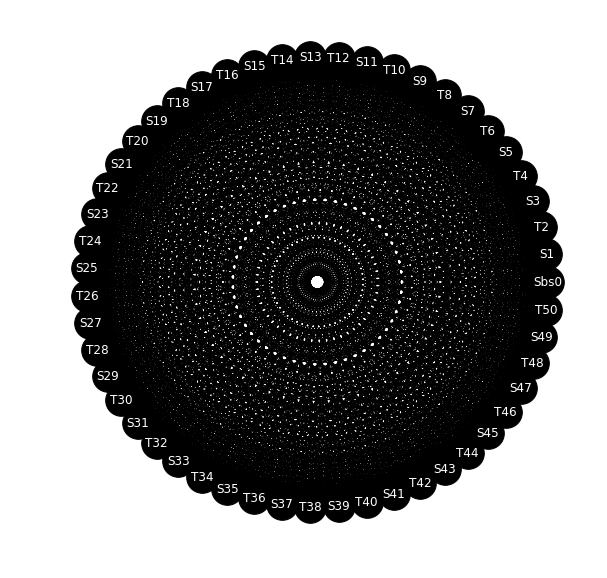

In [4]:
pos=nx.shell_layout(G)

node_lab={}
for i in G.nodes():
    if G.node[i]['tp'] == 1:
        node_lab[i]='S'+str(i)
    elif G.node[i]['tp'] == 0:
        node_lab[i]='T'+str(i)
    elif G.node[i]['tp'] == -1:
        node_lab[i]='Sbs'+str(i)

        
plt.figure(figsize=(10,10))

nx.draw_networkx_labels (G,pos, labels=node_lab,font_color='white')
nx.draw(G, pos, with_labels=False, node_color ='k', node_size=1000)

The function 'distanza' is a function that allow to calculate the Euclidean distance between two nodes. This function is used into formula of cost $c^{t}_{i,j}$ for objective function.

In [5]:
def distanza(P1, P2):
    from math import sqrt
    x1,y1=P1
    x2,y2=P2
    return sqrt((x1-x2)**2+(y1-y2)**2)

In this box I declared the variable for our model that are $x^t_{i,j}, y_{i,j}$ and $f_{i,j}$.

In [6]:
opt_wind_farm_c = gb.Model()

D=[] #type of cable for each edge

for i,j in G.edges():
    for cable in range(0,len(cables)):
       D.append((i,j,cable))
    
f = opt_wind_farm_c.addVars(G.edges(), \
                        lb=0.0,\
                        vtype=gb.GRB.CONTINUOUS,\
                        name='f')

y=opt_wind_farm_c.addVars(G.edges(), \
                        lb=0.0,\
                        ub=1.0,\
                        vtype=gb.GRB.BINARY,\
                        name='y')

x= opt_wind_farm_c.addVars(D, \
                        lb=0.0, \
                        ub=1.0, \
                        obj=[cable['unit']*distanza(pos[i],pos[j]) for i,j in G.edges() for cable in cables],\
                        vtype=gb.GRB.BINARY,\
                        name='x')


opt_wind_farm_c.update()
opt_wind_farm_c.write('opt_wind_farm_c.lp')

Here, I insert in the our model the constraints that constrain the use of a cable for each built arc.

In [7]:
for i,j in G.edges():
    sum_for_cable=gb.quicksum(x[i,j,cable] for cable in range(0,len(cables)))
    opt_wind_farm_c.addConstr((sum_for_cable == y[i,j]), name="2Constraints")
    
opt_wind_farm_c.update()
opt_wind_farm_c.write('opt_wind_farm_c.lp')

These constraints say that the flow of energy entering in each node of $V_{t}$ and $V_{s}$ partitions is equal to energy exiting plus the power production of that node.

In [8]:
for h in G.nodes():
    if (G.node[h]['tp']) == 0:
        opt_wind_farm_c.addConstr(f.sum(h,'*') - f.sum('*',h) == 8, name="3Constraints")
    elif G.node[h]['tp'] == 1:
            opt_wind_farm_c.addConstr(f.sum(h,'*') - f.sum('*',h) == 0, name="3Constraints")

opt_wind_farm_c.update()
opt_wind_farm_c.write('opt_wind_farm_c.lp')

Here, the constraints ensure that the flow ${f_{i,j}}$ does not exceed the capacity $k_{t}$ of the cable $t$.

In [9]:
for i,j in G.edges():
    sum_for_cable=gb.quicksum(cables[cable]["flow_max"]*x[i,j,cable] for cable in range(0,len(cables)))
    opt_wind_farm_c.addConstr((sum_for_cable >= f[i,j]), name="4Constraints")
opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

These constraints impose that only one cable leaves a turbine.

In [10]:
opt_wind_farm_c.addConstrs((y.sum(h,'*') == 1
                         for h in G.nodes() 
                         if G.node[h]['tp'] == 0  ), name="5Constraints")



opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

Here, the constraints say that the substation has no cable exiting.

In [11]:
opt_wind_farm_c.addConstrs((y.sum(h,'*') == 0 
                         for h in G.nodes()
                         if G.node[h]['tp'] == -1 ), name="6Constraints")

opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

The constraints 7 and 8 say that the Steiner nodes is optional to connect them but if they are connected, only one cable can enter and can exit from/to these nodes.

In [12]:
opt_wind_farm_c.addConstrs((y.sum(h,'*') <= 1 
                         for h in G.nodes() 
                         if G.node[h]['tp'] == 1  ), name="7Constraints")

opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

In [13]:
opt_wind_farm_c.addConstrs((y.sum('*',h) <= 1
                         for h in G.nodes() 
                         if G.node[h]['tp'] == 1 ), name="8Constraints")

opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

These constraints impose that each substation can have the maximum number of cable can enter.

In [14]:
opt_wind_farm_c.addConstrs((y.sum('*',h) <= max_cable_subst
                         for h in G.nodes() 
                         if G.node[h]['tp'] == -1 ), name="9Constraints")

opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

These function is used to find the intersection between two arc. It is usefull for next constraints.

In [15]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

In [16]:
collisions=[]
for i,j in G.edges():
    for k,h in G.edges():
        if (k!=i and h!=j and k!=j and h!=i):
            if(intersect(pos[i],pos[j],pos[k],pos[h])):
                collisions.append([(i,j),(k,h)])

The last box contain the constraints that say if there are two crossing arcs, only one can be built.

In [17]:
for cross in collisions:
    opt_wind_farm_c.addConstr((y[cross[0]]+y[cross[1]]+y[(cross[0][1],cross[0][0])]+y[(cross[1][1],cross[1][0])]<= 1), name="10Constraints")

opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

In [18]:
opt_wind_farm_c.optimize()

Optimize a model with 2004427 rows, 12750 columns and 8026050 nonzeros
Variable types: 2550 continuous, 10200 integer (10200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+01]
  Objective range  [5e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 1749401 rows and 250 columns (presolve time = 6s) ...
Presolve removed 1751473 rows and 324 columns (presolve time = 10s) ...
Presolve removed 1758552 rows and 324 columns (presolve time = 15s) ...
Presolve removed 1766109 rows and 324 columns (presolve time = 20s) ...
Presolve removed 1772589 rows and 324 columns (presolve time = 25s) ...
Presolve removed 1776926 rows and 324 columns (presolve time = 30s) ...
Presolve removed 1780470 rows and 324 columns (presolve time = 35s) ...
Presolve removed 1785685 rows and 324 columns (presolve time = 40s) ...
Presolve removed 1792433 rows and 324 columns (presolve time = 45s) ...
Presolve removed 1798380 rows and 324 columns (presolve time

     0     0 4459.12282    0  211 4713.40688 4459.12282  5.39%     -  571s
     0     0 4459.14813    0  206 4713.40688 4459.14813  5.39%     -  572s
     0     0 4461.04726    0  234 4713.40688 4461.04726  5.35%     -  572s
     0     0 4461.40499    0  223 4713.40688 4461.40499  5.35%     -  573s
     0     0 4461.46931    0  214 4713.40688 4461.46931  5.35%     -  573s
     0     0 4461.49061    0  229 4713.40688 4461.49061  5.34%     -  573s
     0     0 4462.56867    0  248 4713.40688 4462.56867  5.32%     -  574s
     0     0 4462.91474    0  247 4713.40688 4462.91474  5.31%     -  574s
     0     0 4463.29014    0  254 4713.40688 4463.29014  5.31%     -  574s
     0     0 4463.48977    0  253 4713.40688 4463.48977  5.30%     -  575s
     0     0 4463.50118    0  254 4713.40688 4463.50118  5.30%     -  575s
     0     0 4466.42099    0  227 4713.40688 4466.42099  5.24%     -  575s
H    0     0                    4713.2233341 4466.42099  5.24%     -  576s
     0     0 4467.22871  

  1437  1182 4518.78584    5  365 4713.22333 4515.84177  4.19%  29.7  980s
  1456  1194 4622.63885  238  391 4713.22333 4516.28522  4.18%  29.3  985s
  1476  1208 4622.63885  238  374 4713.22333 4516.72767  4.17%  28.9  990s
  1502  1225 4517.06290    5  365 4713.22333 4517.06290  4.16%  28.4  995s
  1507  1228 4518.78584    5  370 4713.22333 4517.09391  4.16%  28.3 1003s
  1509  1230 4686.36591  250  370 4713.22333 4517.09391  4.16%  28.3 1007s
  1510  1233 4517.31545   24  355 4713.22333 4517.31545  4.16%  34.5 1020s
  1534  1247 4522.89882   30  300 4713.22333 4522.89882  4.04%  38.4 1025s
  1570  1267 4580.87450   37  226 4713.22333 4527.96133  3.93%  42.6 1030s
  1628  1288 4539.10350   46  282 4713.22333 4527.96133  3.93%  47.4 1036s
  1670  1292 4546.96715   52  267 4713.22333 4527.96133  3.93%  50.7 1040s
  1716  1299 4553.11381   62  273 4713.22333 4527.96133  3.93%  55.2 1045s
  1762  1296 4557.83144   70  259 4713.22333 4527.96133  3.93%  59.0 1050s
  1814  1291 4562.80445  

 14716  5630 4594.44994   72  387 4668.76492 4554.44910  2.45%  65.7 1685s
 14733  5641 4635.14714  240  379 4668.76492 4554.44910  2.45%  65.7 1690s
 14748  5651 4574.03889   52  376 4668.76492 4554.44910  2.45%  65.6 1699s
 14751  5653 4585.64680  130  375 4668.76492 4554.44910  2.45%  65.6 1700s
 14755  5656 4634.00912   84  389 4668.76492 4554.44910  2.45%  65.6 1706s
 14757  5657 4621.12650  154  387 4668.76492 4554.44910  2.45%  65.6 1714s
 14760  5659 4602.15444   71  392 4668.76492 4554.44910  2.45%  65.5 1715s
 14776  5670 4594.44994   72  396 4668.76492 4554.44910  2.45%  65.5 1720s
 14795  5682 4634.00912   84  381 4668.76492 4554.44910  2.45%  65.4 1725s
 14816  5696 4594.44994   72  367 4668.76492 4554.44910  2.45%  65.3 1730s
 14831  5706 4585.64680  130  375 4668.76492 4554.44910  2.45%  65.2 1735s
 14833  5708 4635.14714  240  381 4668.76492 4554.44910  2.45%  65.2 1745s
 14835  5709 4634.00912   84  381 4668.76492 4554.44910  2.45%  65.2 1752s
 14836  5713 4554.44910  

 28203  4572 4655.66421   97  147 4656.78494 4619.83360  0.79%  94.2 2878s
 28361  4504 4655.81891   61  231 4656.78494 4620.43181  0.78%  94.4 2946s
 28479  4463     cutoff   68      4656.78494 4620.78472  0.77%  94.5 2954s
 28616  4399     cutoff   88      4656.78494 4621.38285  0.76%  94.5 2956s
 28672  4339     cutoff   71      4656.78494 4621.88594  0.75%  94.6 2960s
 28795  4278 4625.91527   59  187 4656.78494 4622.39139  0.74%  94.6 2966s
 28918  4221     cutoff   68      4656.78494 4622.94292  0.73%  94.6 2970s
 29099  4113     cutoff   77      4656.78494 4623.77623  0.71%  94.9 2982s
 29274  4064 4628.82629   61  322 4656.78494 4624.17544  0.70%  95.0 2985s
 29365  4000     cutoff   75      4656.78494 4624.68657  0.69%  95.0 2990s
 29494  3939     cutoff   95      4656.78494 4625.02429  0.68%  95.1 2997s
 29576  3880     cutoff   51      4656.78494 4625.32676  0.68%  95.3 3001s
 29760  3762 infeasible   76      4656.78494 4626.11628  0.66%  95.4 3009s
 29848  3708 infeasible  

The next three box there are the code for building the graph of solution.
I have copied the initially graph and I deleted all the nodes and arcs that don't belong to solution found.

In [20]:
S=G.copy()
clean2=[]
good_edge=[]
for v in opt_wind_farm_c.getVars():
    if v.x > 0:
        #print ('%s=%g' % (v.varName, v.x), end = ' ')
        if v.varName.startswith('y'):
            clean=v.varName.replace('y[','').replace(']','').split(',')
            good_edge.append((eval(clean[0]),eval(clean[1])))
            for i in clean:
                clean2.append(eval(i))
node_delete=[]
edge_delete=[]
for j in G.nodes():
    if j not in clean2:
        clean.append(j)
for i in G.edges():
    if i not in good_edge:
        edge_delete.append(i)
        
S.remove_nodes_from(clean)
S.remove_edges_from(edge_delete)

In [64]:
activated_edge_black=[]
activated_edge_green=[]
activated_edge_blue=[]

for i,j in S.edges():
    for cable in range(0,len(cables)):
        if x[i,j,cable].x > 0 and cables[cable]['type'] == 'black':
            activated_edge_black.append((i,j))
        elif x[i,j,cable].x > 0 and cables[cable]['type'] == 'green':
            activated_edge_green.append((i,j))
        elif x[i,j,cable].x > 0 and cables[cable]['type'] == 'blue':
            activated_edge_blue.append((i,j))
        if x[i,j,cable].x > 0:
            if S.node[i]['tp'] == 1:
                node_lab[i]='S'+str(i)
            elif S.node[i]['tp'] == 0:
                node_lab[i]='T'+str(i)
            elif S.node[i]['tp'] == -1:
                node_lab[i]='Sbs'+str(i)    

The color of each arch indicates the type of cable used to connect the nodes.

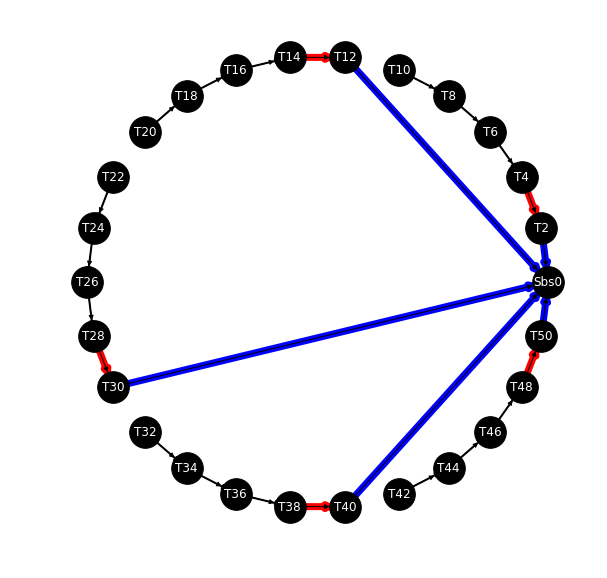

In [66]:
node_lab={}
for i in S.nodes():
    if S.node[i]['tp'] == 1:
        node_lab[i]='S'+str(i)
    elif S.node[i]['tp'] == 0:
        node_lab[i]='T'+str(i)
    elif S.node[i]['tp'] == -1:
        node_lab[i]='Sbs'+str(i)

pos=nx.shell_layout(S)
 
plt.figure(figsize=(10,10))

nx.draw_networkx_edges (S, pos,with_labels=True,edgelist=activated_edge_black, edge_color='black',width=2)
nx.draw_networkx_edges (S, pos,with_labels=True,edgelist=activated_edge_green, edge_color='r',width=7)
nx.draw_networkx_edges (S, pos,with_labels=True,edgelist=activated_edge_blue, edge_color='b',width=7)

nx.draw_networkx_labels (S,pos, labels=node_lab,font_color='white')
nx.draw(S, pos, node_color ='k', node_size=1000)